# GCHP Basic Data Visualization

~ Lizzie Lundgren, 8/17/2018

## Overview of this Notebook

* Import dependencies
* Define data sources
* Explore GCHP data using xarray and numpy
* Define functions for regridding (cubed sphere -> lat/lon)
* Create regridding weights
* Define function to make plots for single vertical level global map
* Define function to make plots for zonal mean
* Save GCHP plots to a pdf

## Import dependencies

In [1]:
import os
import numpy as np
import xarray as xr
import cubedsphere as cs
import xesmf as xe
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from cartopy import crs
from cartopy.mpl.geoaxes import GeoAxes

%matplotlib inline
import warnings; warnings.filterwarnings("ignore")

# Also define colormap. Colormap file source: https://bitbucket.org/gcst/gcpy
rgb_WhGrYlRd = np.genfromtxt('/n/home08/elundgren/GC/python/WhGrYlRd.txt',delimiter=' ')
WhGrYlRd = ListedColormap(rgb_WhGrYlRd/255.0)

## Define data sources

In [2]:
# High-level data directory
datadir = '/n/home08/elundgren/GC/testruns/12.0.0/Aug01'

# GCHP subdirectory
f2datadir = 'gchp_benchmark/OutputDir'

### Print data files for GCHP

In [3]:
GCHP_files = [k for k in os.listdir(os.path.join(datadir,f2datadir)) if '.nc4' in k]
for k in GCHP_files:
    print(k)

GCHP.Emissions.20160716_1200z.nc4
GCHP.LevelEdgeDiags.20160716_1200z.nc4
GCHP.Aerosols.20160716_1200z.nc4
GCHP.JValues.20160716_1200z.nc4
GCHP.ConcAfterChem.20160716_1200z.nc4
GCHP.WetLossConv.20160716_1200z.nc4
GCHP.StateMet_inst.20160801_0000z.nc4
GCHP.DryDep.20160716_1200z.nc4
GCHP.ProdLoss.20160716_1200z.nc4
GCHP.SpeciesConc_inst.20160801_0000z.nc4
GCHP.WetLossLS.20160716_1200z.nc4
GCHP.SpeciesConc_avg.20160716_1200z.nc4
GCHP.CloudConvFlux.20160716_1200z.nc4
GCHP.StateMet_avg.20160716_1200z.nc4
GCHP.StateChm.20160716_1200z.nc4
GCHP.AerosolMass.20160716_1200z.nc4


### Define common filename for easy path generation, and write functions to get paths

In [4]:
# GCHP
f2day = '20160716' # YYYYMMDD
f2time='1200'      # HHmm: GCHP filename shows mid-point time of time-averaging period

In [5]:
def get_gchp_filepath(datadir, modeldir, collection, day, time):
    filepath = os.path.join(datadir, modeldir, 'GCHP.{}.{}_{}z.nc4'.format(collection,day,time))
    print('GCHP data path: {}'.format(filepath))
    return filepath

## Explore GCHP data using xarray and numpy

### Get file paths for one collection (set of diagnostics)

In [6]:
collection = 'Aerosols'
f2 = get_gchp_filepath(datadir, f2datadir, collection, f2day, f2time)

GCHP data path: /n/home08/elundgren/GC/testruns/12.0.0/Aug01/gchp_benchmark/OutputDir/GCHP.Aerosols.20160716_1200z.nc4


### Inspect GCHP xarray dataset

In [7]:
ds2 = xr.open_dataset(f2)
ds2

<xarray.Dataset>
Dimensions:                        (lat: 288, lev: 72, lon: 48, time: 1)
Coordinates:
  * lon                            (lon) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 ...
  * lat                            (lat) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 ...
  * lev                            (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 ...
  * time                           (time) datetime64[ns] 2016-07-16T12:00:00
Data variables:
    AODDust                        (time, lev, lat, lon) float64 3.326e-06 ...
    AODDustWL1_bin1                (time, lev, lat, lon) float64 3.899e-08 ...
    AODDustWL1_bin2                (time, lev, lat, lon) float64 2.555e-07 ...
    AODDustWL1_bin3                (time, lev, lat, lon) float64 1.202e-06 ...
    AODDustWL1_bin4                (time, lev, lat, lon) float64 1.238e-06 ...
    AODDustWL1_bin5                (time, lev, lat, lon) float64 2.84e-07 ...
    AODDustWL1_bin6                (time, lev, lat, lon) float64 2.391e-07 ...
    AODDu

### Get lists of variable names (all, 2D, and 3D)


In [8]:
def get_varnames(dgchp):
    varsAll = [k for k in dgchp.data_vars.keys()]
    vars2D = [v for v in varsAll if dgchp[v].ndim == 3]
    vars3D = [v for v in varsAll if dgchp[v].ndim == 4]
    print('{} variables ({} are 2-dim and {} are 3-dim)'.format(len(varsAll), len(vars2D), len(vars3D)))
    return [varsAll, vars2D, vars3D]

In [9]:
[varsAll, vars2D, vars3D] = get_varnames(ds2)
varsAll

100 variables (0 are 2-dim and 100 are 3-dim)


['AODDust',
 'AODDustWL1_bin1',
 'AODDustWL1_bin2',
 'AODDustWL1_bin3',
 'AODDustWL1_bin4',
 'AODDustWL1_bin5',
 'AODDustWL1_bin6',
 'AODDustWL1_bin7',
 'AODHygWL1_BCPI',
 'AODHygWL1_OCPI',
 'AODHygWL1_SALA',
 'AODHygWL1_SALC',
 'AODHygWL1_SO4',
 'AODPolarStratCloudWL1',
 'AODSOAfromAqIsopreneWL1',
 'AODStratLiquidAerWL1',
 'AerAqueousVolume',
 'AerHygroscopicGrowth_BCPI',
 'AerHygroscopicGrowth_OCPI',
 'AerHygroscopicGrowth_SALA',
 'AerHygroscopicGrowth_SALC',
 'AerHygroscopicGrowth_SO4',
 'AerNumDensityStratLiquid',
 'AerNumDensityStratParticulate',
 'AerSurfAreaDust',
 'AerSurfAreaHyg_BCPI',
 'AerSurfAreaHyg_OCPI',
 'AerSurfAreaHyg_SALA',
 'AerSurfAreaHyg_SALC',
 'AerSurfAreaHyg_SO4',
 'AerSurfAreaPolarStratCloud',
 'AerSurfAreaStratLiquid',
 'Chem_AeroAreaBC',
 'Chem_AeroAreaBGSULF',
 'Chem_AeroAreaICEI',
 'Chem_AeroAreaMDUST1',
 'Chem_AeroAreaMDUST2',
 'Chem_AeroAreaMDUST3',
 'Chem_AeroAreaMDUST4',
 'Chem_AeroAreaMDUST5',
 'Chem_AeroAreaMDUST6',
 'Chem_AeroAreaMDUST7',
 'Chem_Aero

### Look at one variable more closely

In [10]:
varname='AODDust'
ds2_data = ds2[varname]
print('Variable array type: {}'.format(type(ds2_data)))
print('Variable values array type: {}'.format(type(ds2_data.values)))

Variable array type: <class 'xarray.core.dataarray.DataArray'>
Variable values array type: <class 'numpy.ndarray'>


### Explore the data values array using numpy. Here is just a very small sampling of the possibilities.

In [11]:
print('Array shape: {}'.format(ds2_data.shape))
print('GCHP mean concentration: {}'.format(ds2_data.values.mean()))

Array shape: (1, 72, 288, 48)
GCHP mean concentration: 0.0004240012133738108


## Define functions for regridding

These functions utilize the xESMF package and the cubedsphere package developed by Jaiwei Zhuang, a graduate student at Harvard University. More specifically I use the cubedsphere package CSGrid class and the xESMF package Regridder class. The latter serves as a wrapper for the ESMF/ESMPy packages. These tools enable simple conservative regridding between lat/lon and cubed sphere horizontal grids as specifically defined by the NASA Global Modeling and Assimilation Office (GMAO). See http://xesmf.readthedocs.io/en/latest/ and https://github.com/JiaweiZhuang/cubedsphere for more information. 

### Function to make lat/lon half-polar grid (native horizontal grid used in GEOS-Chem Classic)

In [12]:
def make_grid_LL(llres):
    [dlat,dlon] = list(map(float, llres.split('x')))
    lon_b = np.linspace(-180 - dlon/2, 180 - dlon/2, int(360/dlon) + 1, endpoint=True)
    lat_b = np.linspace(-90 - dlat/2, 90 + dlat/2, int(180/dlat) + 2, endpoint=True).clip(-90,90)
    lat = (lat_b[1:] + lat_b[:-1]) / 2
    lon = (lon_b[1:] + lon_b[:-1]) / 2
    llgrid = {'lat': lat, 
              'lon': lon, 
              'lat_b': lat_b, 
              'lon_b': lon_b}
    return llgrid

### Function to make GMAO cubed sphere grid (native horizontal grid used in GCHP)

In [13]:
def make_grid_CS(csres):
    csgrid = cs.csgrid_GMAO(csres)
    csgrid_list = [None]*6
    for i in range(6):
        csgrid_list[i] = {'lat': csgrid['lat'][i], 
                          'lon': csgrid['lon'][i],
                          'lat_b': csgrid['lat_b'][i], 
                          'lon_b': csgrid['lon_b'][i]}
    return [csgrid, csgrid_list]

### Function to create a regridder object for regridding cubed sphere to lat-lon

In [14]:
def make_regridder_C2L( csres_in, llres_out, weightsdir='.', reuse_weights=False,  ):
    csgrid, csgrid_list = make_grid_CS(csres_in)
    llgrid = make_grid_LL(llres_out)
    regridder_list = []
    for i in range(6):
        weightsfile = os.path.join(weightsdir, 'conservative_c{}_{}_{}.nc'.format(str(csres_in), llres_out, str(i)))
        regridder = xe.Regridder(csgrid_list[i], llgrid, method='conservative', filename=weightsfile, reuse_weights=reuse_weights)
        regridder_list.append(regridder)
    return regridder_list

### Function to create a regridder object for regridding between different resolution between lat-lon grids

This is not used for plotting GCHP but is included for general reference.

In [15]:
def make_regridder_L2L( llres_in, llres_out, weightsdir='.', reuse_weights=False ):
    llgrid_in = make_grid_LL(llres_in)
    llgrid_out = make_grid_LL(llres_out)
    weightsfile = os.path.join(weightsdir,'conservative_{}_{}.nc'.format(llres_in, llres_out))
    regridder = xe.Regridder(llgrid_in, llgrid_out, method='conservative', filename=weightsfile, reuse_weights=reuse_weights)
    return regridder

### Make a 4x5 grid container

This is to help better understand the lat-lon grid container. Note that this is the resolution and grid of my GCC data.

In [16]:
llgrid = make_grid_LL('4x5')
print([[k, llgrid[k].shape] for k in llgrid.keys()])
print('lat:\n {}'.format(llgrid['lat']))
print('lat_b:\n {}'.format(llgrid['lat_b']))
print('lon:\n {}'.format(llgrid['lon']))
print('lon_b:\n {}'.format(llgrid['lon_b']))

[['lat', (46,)], ['lon', (72,)], ['lat_b', (47,)], ['lon_b', (73,)]]
lat:
 [-89. -86. -82. -78. -74. -70. -66. -62. -58. -54. -50. -46. -42. -38. -34.
 -30. -26. -22. -18. -14. -10.  -6.  -2.   2.   6.  10.  14.  18.  22.  26.
  30.  34.  38.  42.  46.  50.  54.  58.  62.  66.  70.  74.  78.  82.  86.
  89.]
lat_b:
 [-90. -88. -84. -80. -76. -72. -68. -64. -60. -56. -52. -48. -44. -40. -36.
 -32. -28. -24. -20. -16. -12.  -8.  -4.   0.   4.   8.  12.  16.  20.  24.
  28.  32.  36.  40.  44.  48.  52.  56.  60.  64.  68.  72.  76.  80.  84.
  88.  90.]
lon:
 [-180. -175. -170. -165. -160. -155. -150. -145. -140. -135. -130. -125.
 -120. -115. -110. -105. -100.  -95.  -90.  -85.  -80.  -75.  -70.  -65.
  -60.  -55.  -50.  -45.  -40.  -35.  -30.  -25.  -20.  -15.  -10.   -5.
    0.    5.   10.   15.   20.   25.   30.   35.   40.   45.   50.   55.
   60.   65.   70.   75.   80.   85.   90.   95.  100.  105.  110.  115.
  120.  125.  130.  135.  140.  145.  150.  155.  160.  165.  170.  175

### Make a c48 grid container

This is to help understand the cubed sphere grid container. Not that this is the resolution and grid of my GCHP data.

In [17]:
csgrid, csgrid_list = make_grid_CS(48)
[[k, csgrid[k].shape] for k in csgrid.keys()]
for i in range(6):
    print([[k,csgrid_list[i][k].shape] for k in csgrid_list[i].keys()]) 

[['lat', (48, 48)], ['lon', (48, 48)], ['lat_b', (49, 49)], ['lon_b', (49, 49)]]
[['lat', (48, 48)], ['lon', (48, 48)], ['lat_b', (49, 49)], ['lon_b', (49, 49)]]
[['lat', (48, 48)], ['lon', (48, 48)], ['lat_b', (49, 49)], ['lon_b', (49, 49)]]
[['lat', (48, 48)], ['lon', (48, 48)], ['lat_b', (49, 49)], ['lon_b', (49, 49)]]
[['lat', (48, 48)], ['lon', (48, 48)], ['lat_b', (49, 49)], ['lon_b', (49, 49)]]
[['lat', (48, 48)], ['lon', (48, 48)], ['lat_b', (49, 49)], ['lon_b', (49, 49)]]


## Create regridding weights for data native resolutions

The xESMF Regridder object can create weights for regridding from one grid resolution to another, or it can be provided weights that are pre-generated to save time. Generating weights therefore only needs to be done once for each combination of input and output grid type and resolution. This can be done by calling the make_regridder functions and passing reuse_weights=False.

Note that create the L2L regridder weights here are included only as an example to show how similar it is to creating cubed sphere to lat-lon weights.

In [18]:
weightsdir = '/n/home08/elundgren/GC/python/regrid_weights'
# This example notebook will regrid from cubed sphere 48 and lat/lon 4x5 to lat/lon 1x1.25.
%timeit regridder_C2L_list = make_regridder_C2L(48, '1x1.25', weightsdir=weightsdir, reuse_weights=False)
regridder_L2L = make_regridder_L2L('4x5', '1x1.25', weightsdir=weightsdir, reuse_weights=False)

19.9 s ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Define function to make plots for single vertical level global map

Note: This function regrids GCHP on-the-fly using the pre-generated weights created above.

In [19]:
def plot_level_map(dgchp, varlist=None, weightsdir='.', ilev=0, itime=0, llres='1x1.25', 
               savepdf=False, pdfname='gchp_map.pdf', full_ratio_range=False, plots='cs_only'):
    
    # If no varlist is passed, plot all (surface only for 3D)
    if varlist == None:
        varlist = [k for k in dgchp.data_vars.keys()]
        print('Plotting all variables in collection')
    n_var = len(varlist)
    
    # Get cubed sphere grid and regridder
    csres = dgchp['lon'].size
    [csgrid, csgrid_list] = make_grid_CS(csres)
    cs_regridder_list = make_regridder_C2L(csres, llres, weightsdir=weightsdir, reuse_weights=True)

    # Get lat/lon grid
    llgrid = make_grid_LL(llres)
    
    # Get lat/lon extents
    [minlon, maxlon] = [min(llgrid['lon_b']), max(llgrid['lon_b'])]
    [minlat, maxlat] = [min(llgrid['lat_b']), max(llgrid['lat_b'])]

    # Create pdf (if saving)
    if savepdf:
        print('\nCreating {}'.format(pdfname))
        pdf = PdfPages(pdfname)

    # Loop over variables
    for ivar in range(n_var):
        if savepdf: print('{} '.format(ivar), end='')
        varname = varlist[ivar]
            
        # if normalizing by area, adjust units to be per m2, and adjust title string
        units = dgchp[varname].units
                    
        # Slice the data
        varndim = dgchp[varname].ndim
        if varndim == 4: 
            ds2 = dgchp[varname].isel(time=itime,lev=ilev)
        elif varndim == 3: 
            ds2 = dgchp[varname].isel(time=itime)
            
        # Regrid the slices
        csdata = ds2.data.reshape(6,csres,csres)
        gchp_ll = np.zeros([llgrid['lat'].size, llgrid['lon'].size])
        for i in range(6):
            regridder = cs_regridder_list[i]
            gchp_ll += regridder(csdata[i])
        
        # Get min and max for colorbar limits
        vmin = np.min([csdata.min(), gchp_ll.min()])
        vmax = np.max([csdata.max(), gchp_ll.max()])
        
        # Plot both cs and lat-lon (default)
        if plots == 'cs_and_ll':
            
            # Create 2x1 figure
            figs, ((ax0), (ax1)) = plt.subplots(2, 1, figsize=[10,14], subplot_kw={'projection': crs.PlateCarree()})
            
            # Give the figure a title
            offset = 0.96
            fontsize=24
            if varndim == 4:
                if ilev == 0: levstr = 'Surface'
                elif ilev == 22: levstr = '500 hPa'
                else: levstr = 'Level ' +  str(ilev-1)
                figs.suptitle('{}, {}'.format(varname,levstr), fontsize=fontsize, y=offset)
            elif varndim == 3: 
                figs.suptitle('{}'.format(varname), fontsize=fontsize, y=offset)
            else:
                print('varndim is 2 for {}! Must be 3 or 4.'.format(varname))
            
            # Subplot (0,0): GCHP raw
            ax0.coastlines()       
            masked_csdata = np.ma.masked_where(np.abs(csgrid['lon'] - 180) < 2, csdata) # based on cubedsphere plotCS_quick_raw
            for i in range(6):
                plot0 = ax0.pcolormesh(csgrid['lon_b'][i,:,:], csgrid['lat_b'][i,:,:], masked_csdata[i,:,:], 
                                       cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
            ax0.set_title('GCHP Raw\nC{}'.format(str(csres)))
            cb = plt.colorbar(plot0, ax=ax0, orientation='horizontal', pad=0.10)
            if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
                cb.locator = ticker.MaxNLocator(nbins=4)
                cb.update_ticks()
            cb.set_label(units)            
        
            # Subplot (0,1): GCHP regridded
            ax1.coastlines()
            plot1 = ax1.imshow(gchp_ll, extent=(minlon, maxlon, minlat, maxlat), 
                               cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
            ax1.set_title('GCHP Regridded\n{}'.format(llres))
            cb = plt.colorbar(plot1, ax=ax1, orientation='horizontal', pad=0.10)
            if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
                cb.locator = ticker.MaxNLocator(nbins=4)
                cb.update_ticks()
            cb.set_label(units)
            
        elif plots == 'cs_only':
            
            # Create single figure
            figs, ((ax0)) = plt.subplots(1, 1, figsize=[14,10], subplot_kw={'projection': crs.PlateCarree()})
            
            # Give the figure a title
            offset = 0.96
            fontsize=24
            if varndim == 4:
                if ilev == 0: levstr = 'Surface'
                elif ilev == 22: levstr = '500 hPa'
                else: levstr = 'Level ' +  str(ilev-1)
                figs.suptitle('{}, {}'.format(varname,levstr), fontsize=fontsize, y=offset)
            elif varndim == 3: 
                figs.suptitle('{}'.format(varname), fontsize=fontsize, y=offset)
            else:
                print('varndim is 2 for {}! Must be 3 or 4.'.format(varname))
            
            # Same as subplot (0,0): GCHP raw
            ax0.coastlines()       
            masked_csdata = np.ma.masked_where(np.abs(csgrid['lon'] - 180) < 2, csdata) # based on cubedsphere plotCS_quick_raw
            for i in range(6):
                plot0 = ax0.pcolormesh(csgrid['lon_b'][i,:,:], csgrid['lat_b'][i,:,:], masked_csdata[i,:,:], 
                                       cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
            ax0.set_title('GCHP Raw\nC{}'.format(str(csres)))
            cb = plt.colorbar(plot0, ax=ax0, orientation='horizontal', pad=0.10)
            if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
                cb.locator = ticker.MaxNLocator(nbins=4)
                cb.update_ticks()
            cb.set_label(units)  
            
        elif plots == 'll_only':
            
            # Create single figure
            figs, ((ax1)) = plt.subplots(1, 1, figsize=[14,10], subplot_kw={'projection': crs.PlateCarree()})
            
            # Give the figure a title
            offset = 0.96
            fontsize=24
            if varndim == 4:
                if ilev == 0: levstr = 'Surface'
                elif ilev == 22: levstr = '500 hPa'
                else: levstr = 'Level ' +  str(ilev-1)
                figs.suptitle('{}, {}'.format(varname,levstr), fontsize=fontsize, y=offset)
            elif varndim == 3: 
                figs.suptitle('{}'.format(varname), fontsize=fontsize, y=offset)
            else:
                print('varndim is 2 for {}! Must be 3 or 4.'.format(varname))
            
            # Same as subplot (0,1): GCHP regridded
            ax1.coastlines()
            plot1 = ax1.imshow(gchp_ll, extent=(minlon, maxlon, minlat, maxlat), 
                               cmap=WhGrYlRd,vmin=vmin, vmax=vmax)
            ax1.set_title('GCHP Regridded\n{}'.format(llres))
            cb = plt.colorbar(plot1, ax=ax1, orientation='horizontal', pad=0.10)
            if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
                cb.locator = ticker.MaxNLocator(nbins=4)
                cb.update_ticks()
            cb.set_label(units)

        else:
            print('Undefined plots argument passed. Use cs_only, ll_only, or nothing for cs and ll')
        
        if savepdf:    
            pdf.savefig(figs)
            plt.close(figs)
            
    if savepdf: pdf.close()

### Example 1: plot surface ozone as cubed sphere
Tip: Use shift-tab to display arguments

CPU times: user 4.85 s, sys: 16 ms, total: 4.87 s
Wall time: 5.45 s


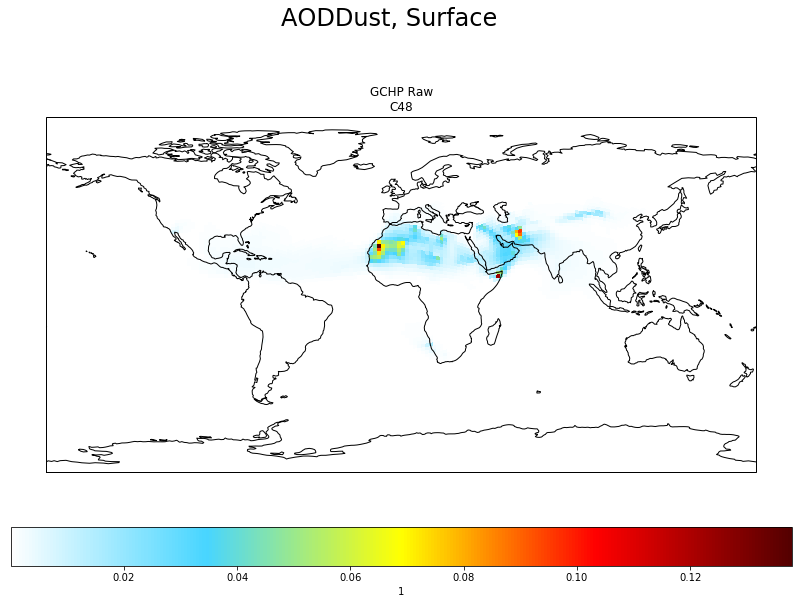

In [20]:
%time plot_level_map(ds2, varlist=[varname], weightsdir=weightsdir, plots='cs_only')

### Example 2: plot ozone at L=22 as lat-lon (default is 1x1.25)

CPU times: user 4.57 s, sys: 7.99 ms, total: 4.58 s
Wall time: 4.71 s


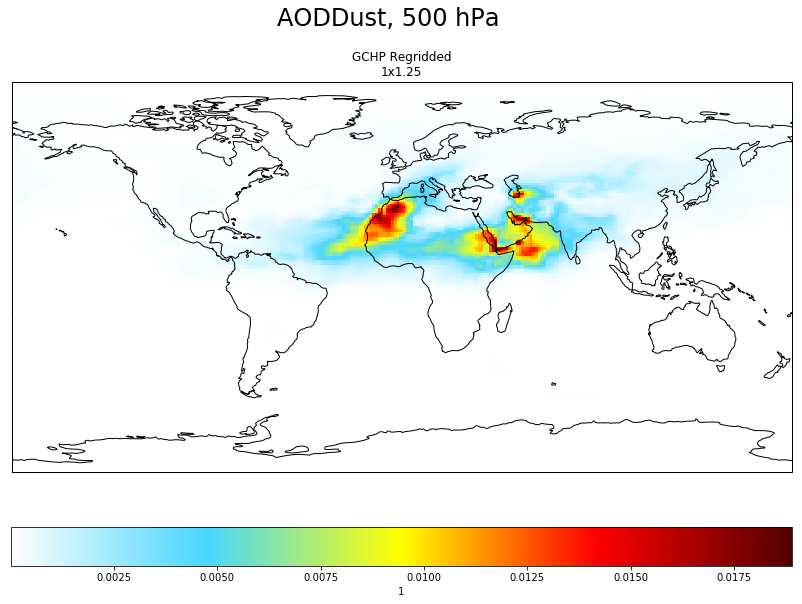

In [21]:
%time plot_level_map(ds2, varlist=[varname], ilev=22, weightsdir=weightsdir, plots='ll_only')

## Define function to make plots for zonal mean

Note: Zonal mean is defined as the mean value across a constant latitudinal band. Calculating zonal mean from cubed sphere is not straight-forward. Regridding to lat/lon prior to calculating and plotting is done here instead.

In [22]:
def plot_zonal_mean(dgchp, varlist=None, weightsdir='.', itime=0, llres='1x1.25', savepdf=False, 
                    pdfname='gchp_zonal_mean.pdf', full_ratio_range=False):

    # If no varlist is passed, plot all 3D variables in the dataset
    if varlist == None:
        varlist = [k for k in dgchp.data_vars.keys() if dgchp[k].ndim == 4]
        print('Plotting all 3D variables in collection')
    n_var = len(varlist)
    
    # Get cubed sphere grid and regridder
    csres = dgchp['lon'].size
    [csgrid, csgrid_list] = make_grid_CS(csres)
    cs_regridder_list = make_regridder_C2L(csres, llres, weightsdir=weightsdir, reuse_weights=True)
    
    # Get lat-lon grid
    llgrid = make_grid_LL(llres)
    
    # Universal plot setup
    xtick_positions = np.arange(-90,91,30)
    xticklabels = ['{}$\degree$'.format(x) for x in xtick_positions]
    ytick_positions = np.arange(0,61,20)
    yticklabels = [str(y) for y in ytick_positions]
    
    # Create pdf (if saving)
    if savepdf:
        print('\nCreating {}'.format(pdfname))
        pdf = PdfPages(pdfname)

    # Loop over variables
    for ivar in range(n_var):
        if savepdf: print('{} '.format(ivar), end='')
        varname = varlist[ivar]
        
        # Basic info
        varndim = dgchp[varname].ndim
        units = dgchp[varname].units
        nlev = 72
        extent=(-90,90,0,nlev)
        
        # Slice the data
        ds2 = dgchp[varname].isel(time=itime)
            
        # Regrid the slices
        csdata = ds2.data.reshape(nlev,6,csres,csres).swapaxes(0,1)
        gchp_ll = np.zeros([nlev, llgrid['lat'].size, llgrid['lon'].size])
        for i in range(6):
            regridder = cs_regridder_list[i]
            gchp_ll += regridder(csdata[i])
        
        # Calculate zonal mean of the regridded data
        gchp_zm = gchp_ll.mean(axis=1)
            
        # Get min and max for colorbar limits
        [vmin, vmax] = [gchp_zm.min(), gchp_zm.max()]
        
        # Create 1x1 figure (leave as subplots for easy addition of more plots in figure)
        figs, ((ax0)) = plt.subplots(1, 1, figsize=[14,10], subplot_kw={'projection': crs.PlateCarree()})
        # Give the page a title
        offset = 0.96
        fontsize=25
        figs.suptitle('{}, Zonal Mean'.format(varname), fontsize=fontsize, y=offset)

        # GCHP regridded
        plot0 = ax0.imshow(gchp_zm, cmap=WhGrYlRd, extent=extent, vmin=vmin, vmax=vmax)
        ax0.set_title('GCHP Regridded\n{}'.format(llres))
        ax0.set_aspect('auto')
        ax0.set_xticks(xtick_positions)
        ax0.set_xticklabels(xticklabels)
        ax0.set_yticks(ytick_positions)
        ax0.set_yticklabels(yticklabels)
        cb = plt.colorbar(plot0, ax=ax0, orientation='horizontal', pad=0.10)
        if (vmax-vmin) < 0.001 or (vmax-vmin) > 1000:
            cb.locator = ticker.MaxNLocator(nbins=4)
            cb.update_ticks()
        cb.set_label(units)
            
        if savepdf:    
            pdf.savefig(figs)
            plt.close(figs)
            
    if savepdf: pdf.close()

### Plot zonal mean of regridded data

Tip: Use shift-tab over the function to see more information


CPU times: user 4.67 s, sys: 42 ms, total: 4.71 s
Wall time: 4.86 s


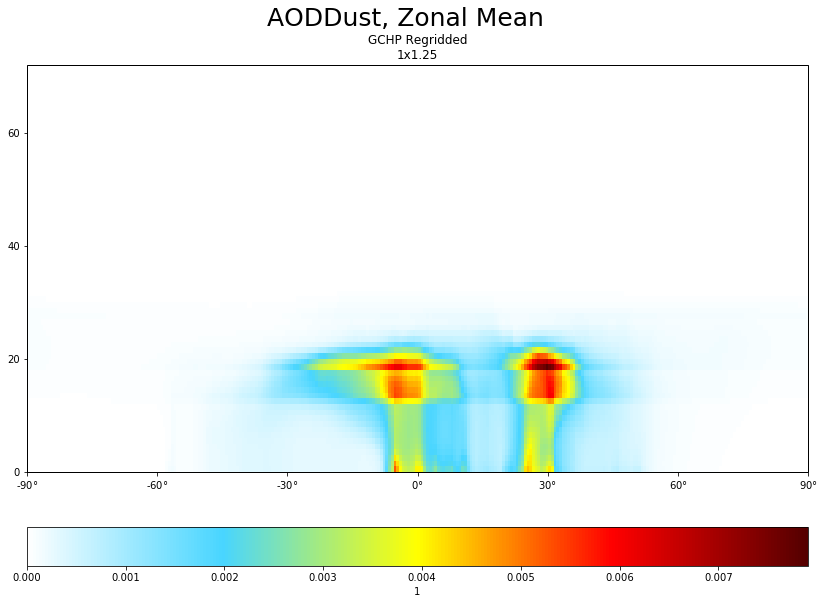

In [23]:
%time plot_zonal_mean(ds2, varlist=[varname], weightsdir=weightsdir )

## Save GCHP plots to a pdf

### Define directory to save plots (must already exist)

In [24]:
plotsdir = os.path.join('.')

### Choose a collection and get data

In [25]:
collection = 'Aerosols'
f2 = get_gchp_filepath(datadir, f2datadir, collection, f2day, f2time)
ds2 = xr.open_dataset(f2)

GCHP data path: /n/home08/elundgren/GC/testruns/12.0.0/Aug01/gchp_benchmark/OutputDir/GCHP.Aerosols.20160716_1200z.nc4


### Inspect variable names as needed and choose which variables to plot

In [26]:
[varsAll, vars2D, vars3D] = get_varnames(ds2)
vars3D

100 variables (0 are 2-dim and 100 are 3-dim)


['AODDust',
 'AODDustWL1_bin1',
 'AODDustWL1_bin2',
 'AODDustWL1_bin3',
 'AODDustWL1_bin4',
 'AODDustWL1_bin5',
 'AODDustWL1_bin6',
 'AODDustWL1_bin7',
 'AODHygWL1_BCPI',
 'AODHygWL1_OCPI',
 'AODHygWL1_SALA',
 'AODHygWL1_SALC',
 'AODHygWL1_SO4',
 'AODPolarStratCloudWL1',
 'AODSOAfromAqIsopreneWL1',
 'AODStratLiquidAerWL1',
 'AerAqueousVolume',
 'AerHygroscopicGrowth_BCPI',
 'AerHygroscopicGrowth_OCPI',
 'AerHygroscopicGrowth_SALA',
 'AerHygroscopicGrowth_SALC',
 'AerHygroscopicGrowth_SO4',
 'AerNumDensityStratLiquid',
 'AerNumDensityStratParticulate',
 'AerSurfAreaDust',
 'AerSurfAreaHyg_BCPI',
 'AerSurfAreaHyg_OCPI',
 'AerSurfAreaHyg_SALA',
 'AerSurfAreaHyg_SALC',
 'AerSurfAreaHyg_SO4',
 'AerSurfAreaPolarStratCloud',
 'AerSurfAreaStratLiquid',
 'Chem_AeroAreaBC',
 'Chem_AeroAreaBGSULF',
 'Chem_AeroAreaICEI',
 'Chem_AeroAreaMDUST1',
 'Chem_AeroAreaMDUST2',
 'Chem_AeroAreaMDUST3',
 'Chem_AeroAreaMDUST4',
 'Chem_AeroAreaMDUST5',
 'Chem_AeroAreaMDUST6',
 'Chem_AeroAreaMDUST7',
 'Chem_Aero

In [27]:
varlist=[k for k in vars3D if 'AerHygroscopic' in k]
varlist

['AerHygroscopicGrowth_BCPI',
 'AerHygroscopicGrowth_OCPI',
 'AerHygroscopicGrowth_SALA',
 'AerHygroscopicGrowth_SALC',
 'AerHygroscopicGrowth_SO4']

### Plot (1) global maps at surface, (2) global maps at level 22, and (3) zonal mean, as three different PDFs

In [28]:
ilev=0
pdfname = os.path.join(plotsdir,'{}_HygroscopicGrowth_surface.pdf'.format(collection))
%time plot_level_map(ds2, varlist=varlist, ilev=ilev, weightsdir=weightsdir, savepdf=True, pdfname=pdfname )


Creating ./Aerosols_HygroscopicGrowth_surface.pdf
0 1 2 3 4 CPU times: user 22 s, sys: 44.8 ms, total: 22.1 s
Wall time: 23.7 s


In [29]:
ilev=22
pdfname = os.path.join(plotsdir,'{}_HygroscopicGrowth_L{}.pdf'.format(collection, ilev))
%time plot_level_map(ds2, varlist=varlist, ilev=ilev, weightsdir=weightsdir, savepdf=True, pdfname=pdfname )


Creating ./Aerosols_HygroscopicGrowth_L22.pdf
0 1 2 3 4 CPU times: user 21.8 s, sys: 20.8 ms, total: 21.8 s
Wall time: 22.5 s


In [30]:
pdfname = os.path.join(plotsdir,'{}_HygroscopicGrowth_zonal_mean.pdf'.format(collection))
%time plot_zonal_mean(ds2, varlist=varlist, weightsdir=weightsdir, savepdf=True, pdfname=pdfname )


Creating ./Aerosols_HygroscopicGrowth_zonal_mean.pdf
0 1 2 3 4 CPU times: user 6.37 s, sys: 79.9 ms, total: 6.45 s
Wall time: 6.85 s
